In [ ]:

import pandas as pd
import numpy as np
#علشان رسومات الجرافيك
import matplotlib.pyplot as plt
import seaborn as sns
#علشان نقسم الداتا ونختبرها ونتدربها
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
#بنستخدمها علشان نقيم المودل من دقة وتقرير وكده
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score)
#علشان نوحد البيانات وتبقى ماشية سوا
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE

In [ ]:
# Load the data
df = pd.read_csv('/content/Final-Merge-withoutPCA.csv')
df_recent = df.sort_values('MONTHS_BALANCE').groupby('ID').first().reset_index()

In [ ]:
#بنحدد ايه الحاجات هنستخدمها علشان نتوقع منها نتيجه ال features
#وايه الحاجة اللي عايزين نتوقعها ال target
features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
            'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
            'CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED']
target = 'STATUS'

X = df_recent[features]
y = df_recent[target]

In [ ]:
# Split and scale
#بنقسم الداتا شوية للتدريب وشوية للتيست علشان نتاكد هو اتعلم كويس فعلا ولا لا ولتجنب الاوفرفيتنج
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Train initial SVM model without hyperparameters
svm_default = SVC()
svm_default.fit(X_train_scaled, y_train)


SVC()

In [ ]:

y_pred_default = svm_default.predict(X_test_scaled)
accuracy_default = accuracy_score(y_test, y_pred_default)
precision_default = precision_score(y_test, y_pred_default, average='macro')
recall_default = recall_score(y_test, y_pred_default, average='macro')
f1_default = f1_score(y_test, y_pred_default, average='macro')

print(f"Accuracy: {accuracy_default* 100:.2f}%")
print(f"Precision: {precision_default* 100:.2f}%")
print(f"Recall: {recall_default* 100:.2f}%")
print(f"F1 Score: {f1_default* 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_default))


Accuracy: 88.34%
Precision: 44.17%
Recall: 49.99%
F1 Score: 46.90%

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      9258
           1       0.00      0.00      0.00      1221

    accuracy                           0.88     10479
   macro avg       0.44      0.50      0.47     10479
weighted avg       0.78      0.88      0.83     10479



In [ ]:
#Apply RandomizedSearchCV to find better hyperparameters

#param_dist = {
 #   'C': [0.1, 1, 10, 100],
  #  'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto'],
  #  'kernel': ['rbf', 'poly', 'sigmoid']
#}

#random_search = RandomizedSearchCV(SVC(probability=True, random_state=42), param_distributions=param_dist,
 #                                  n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=-1)
#random_search.fit(X_train_scaled, y_train)

#print("Best Parameters from RandomizedSearchCV:")
#print(random_search.best_params_)

In [ ]:
# Train new SVM model with best hyperparameters
#svm_best = random_search.best_estimator_
#svm_best.fit(X_train_scaled, y_train)

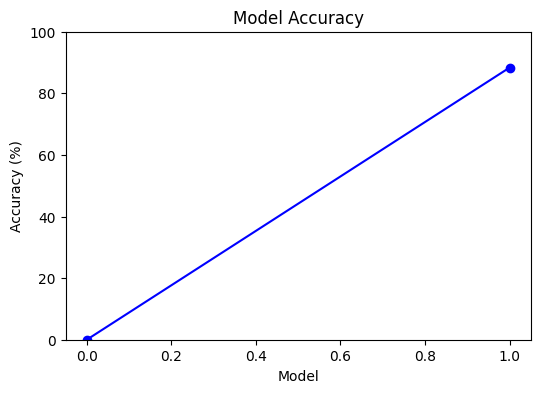

In [ ]:
#Accuracy Plo=رسم بياني هيوريني دقه الموديل

plt.figure(figsize=(6,4))
plt.plot([0, 1], [0, accuracy_default * 100], marker='o', color='b')
plt.title('Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()


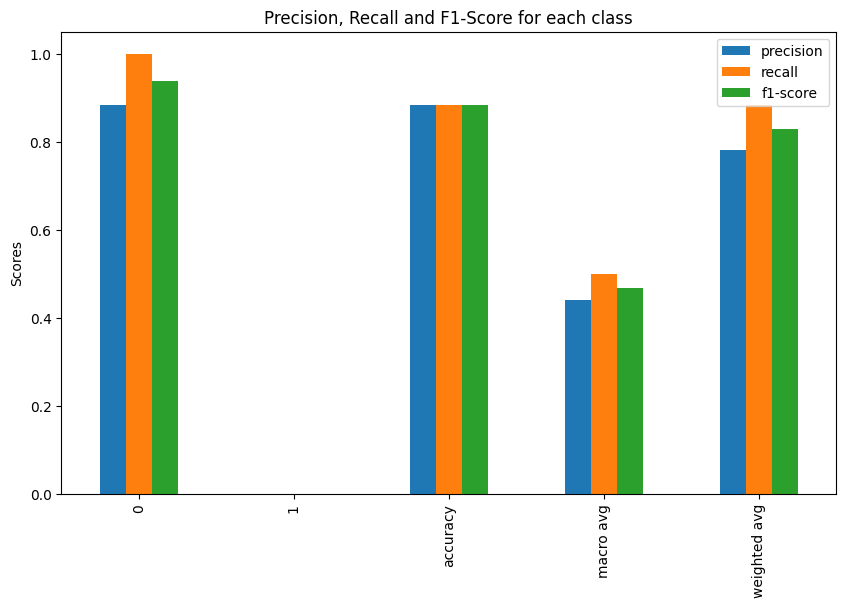

In [ ]:
#دقة الموديل (Accuracy)، الـ Recall، والـ F1-Score لكل فئة
report = classification_report(y_test, y_pred_default, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10,6))
plt.title('Precision, Recall and F1-Score for each class')
plt.ylabel('Scores')
plt.show()


Confusion Matrix:
[[9257    1]
 [1221    0]]


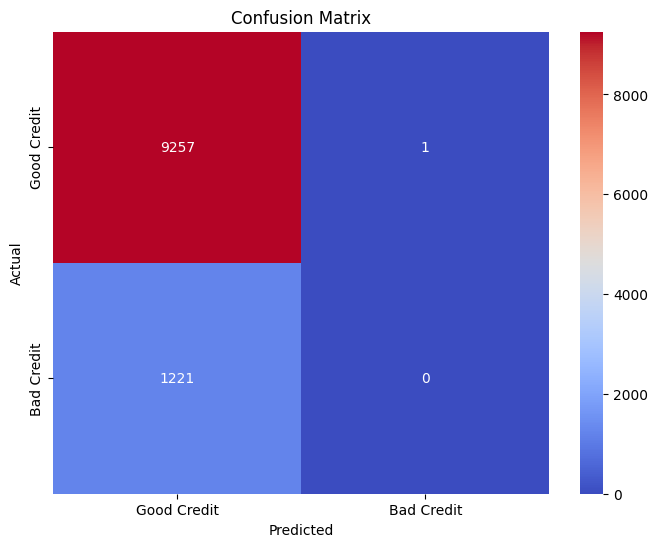

In [ ]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_test,y_pred_default)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Good Credit', 'Bad Credit'],
            yticklabels=['Good Credit', 'Bad Credit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

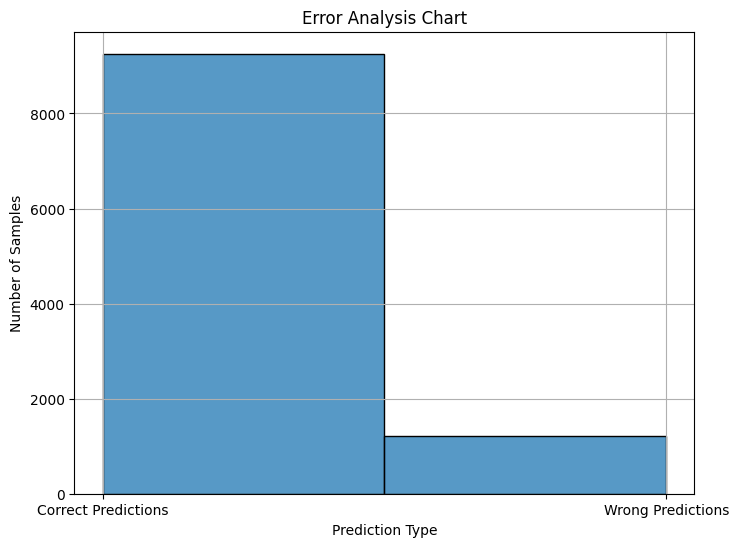

In [ ]:
# نعمل تحليل للأخطاء
errors = (y_pred_default != y_test)

plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=2, kde=False)
plt.xticks([0, 1], ['Correct Predictions', 'Wrong Predictions'])
plt.title('Error Analysis Chart')
plt.xlabel('Prediction Type')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()


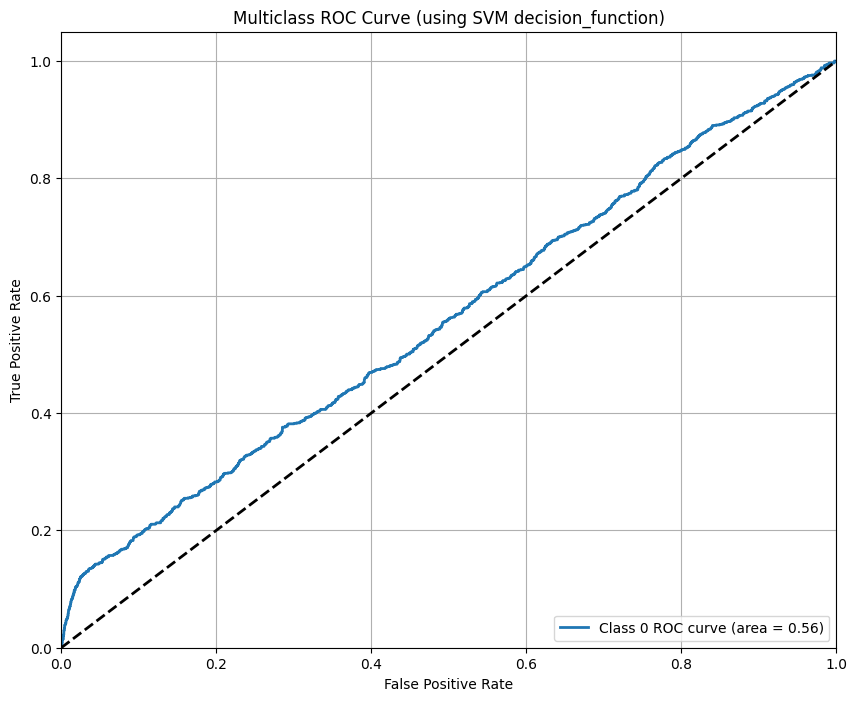

In [ ]:

# ROC Curve
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

y_score = svm_default.decision_function(X_test_scaled)
if n_classes == 1:
    y_score = y_score.reshape(-1, 1)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (using SVM decision_function)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
# Train SVM model
#بنعمل Hyperparameters علشان نتحكم في شغل المودل وادائه
#الkernel بيبقى طرقه فصل البيانات ودي الطرقة الدايرة
#وال c بيتحكم في مدى سامحنا للاخطاء
svm_best = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_best.fit(X_resampled, y_resampled)


SVC(probability=True, random_state=42)

In [ ]:
# Predictions and evaluation after hyperparameter tuning
y_pred_best = svm_best.predict(X_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, average='macro')
recall_best = recall_score(y_test, y_pred_best, average='macro')
f1_best = f1_score(y_test, y_pred_best, average='macro')

print(f"Accuracy: {accuracy_best* 100:.2f}%")
print(f"Precision: {precision_best* 100:.2f}%")
print(f"Recall: {recall_best* 100:.2f}%")
print(f"F1 Score: {f1_best* 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

Accuracy: 57.65%
Precision: 52.24%
Recall: 55.34%
F1 Score: 46.62%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.58      0.71      9258
           1       0.14      0.52      0.22      1221

    accuracy                           0.58     10479
   macro avg       0.52      0.55      0.47     10479
weighted avg       0.81      0.58      0.65     10479



In [ ]:
#Compare results
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Before Tuning': [accuracy_default, precision_default, recall_default, f1_default],
    'After Tuning': [accuracy_best, precision_best, recall_best, f1_best]
})

print("\nComparison Table:")
print(comparison_df)



Comparison Table:
      Metric  Before Tuning  After Tuning
0   Accuracy       0.883386      0.576486
1  Precision       0.441735      0.522449
2     Recall       0.499946      0.553418
3   F1 Score       0.469041      0.466207


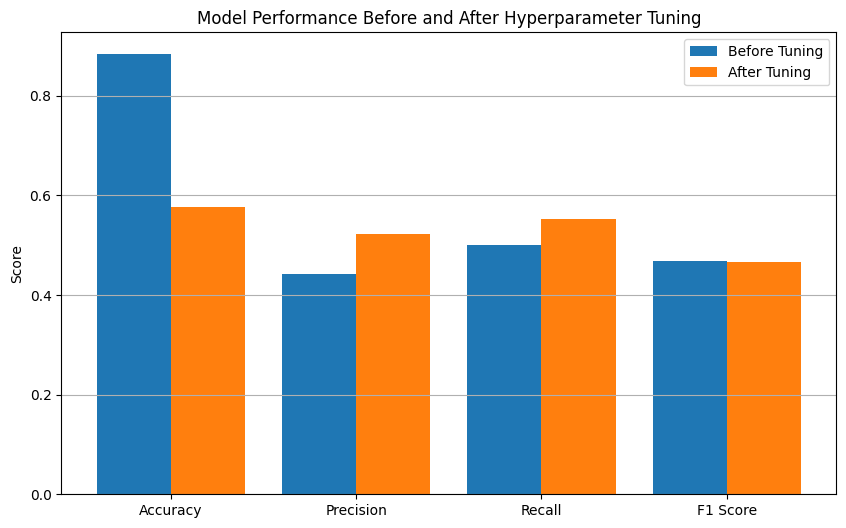

In [ ]:
#Plot the comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = range(len(metrics))

plt.figure(figsize=(10,6))
plt.bar(x, comparison_df['Before Tuning'], width=0.4, label='Before Tuning', align='center')
plt.bar([i + 0.4 for i in x], comparison_df['After Tuning'], width=0.4, label='After Tuning', align='center')

plt.xticks([i + 0.2 for i in x], metrics)
plt.ylabel('Score')
plt.title('Model Performance Before and After Hyperparameter Tuning')
plt.legend()
plt.grid(axis='y')
plt.show()


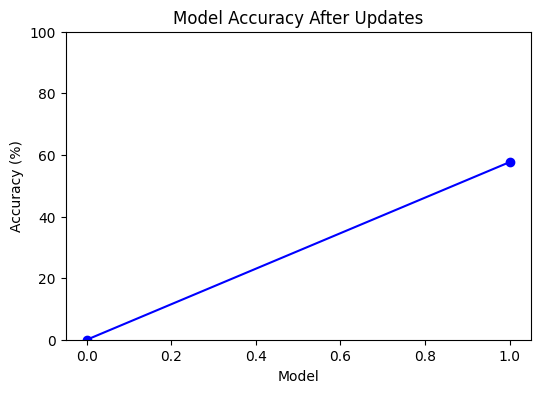

In [ ]:
#Accuracy رسم بياني هيوريني دقه الموديل بعد الابديت

plt.figure(figsize=(6,4))
plt.plot([0, 1], [0, accuracy_best * 100], marker='o', color='b')
plt.title('Model Accuracy After Updates')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()


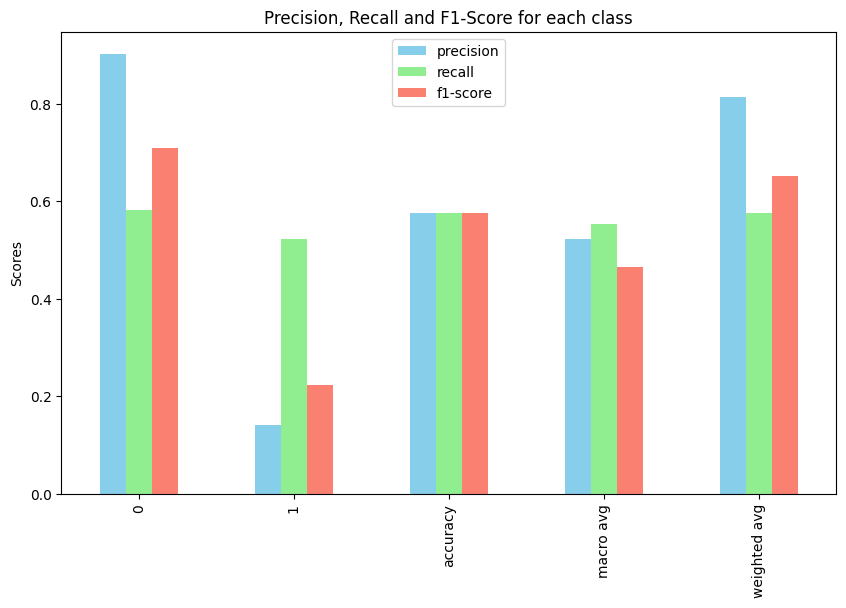

In [ ]:
#دقة الموديل (Accuracy)، الـ Recall، والـ F1-Score لكل فئة
report = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10,6), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Precision, Recall and F1-Score for each class')
plt.ylabel('Scores')
plt.show()


Confusion Matrix:
[[5402 3856]
 [ 582  639]]


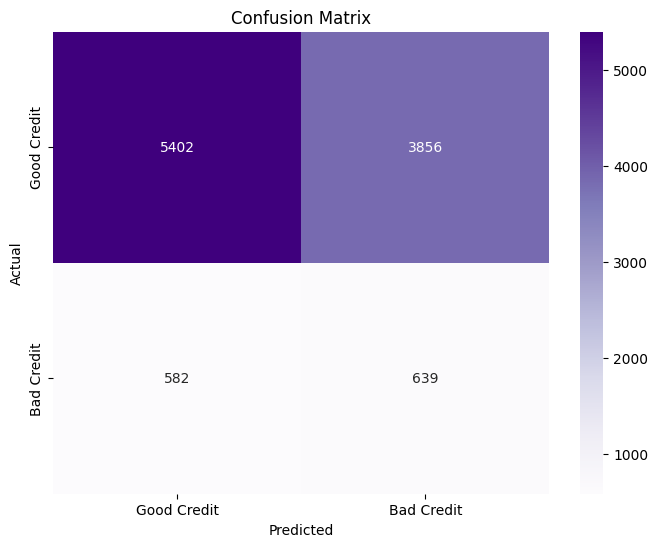

In [ ]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_test,y_pred_best)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Good Credit', 'Bad Credit'],
            yticklabels=['Good Credit', 'Bad Credit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:

# نرسم الـ Learning Curve
#train_sizes, train_scores, test_scores = learning_curve(
 #   svm_best , X_resampled, y_resampled, cv=5, scoring='accuracy', n_jobs=-1,
  #  train_sizes=np.linspace(0.1, 1.0, 5)
#)

#train_scores_mean = np.mean(train_scores, axis=1)
#test_scores_mean = np.mean(test_scores, axis=1)

#plt.figure(figsize=(10, 6))
#plt.plot(train_sizes, train_scores_mean, 'o-', color='crimson', label='Training Score')
#plt.plot(train_sizes, test_scores_mean, 'o-', color='seagreen', label='Cross-Validation Score')
#plt.title('Learning Curve (SVM)')
#plt.xlabel('Training Set Size')
#plt.ylabel('Accuracy')
#plt.legend(loc='best')
#plt.grid(True)
#plt.show()


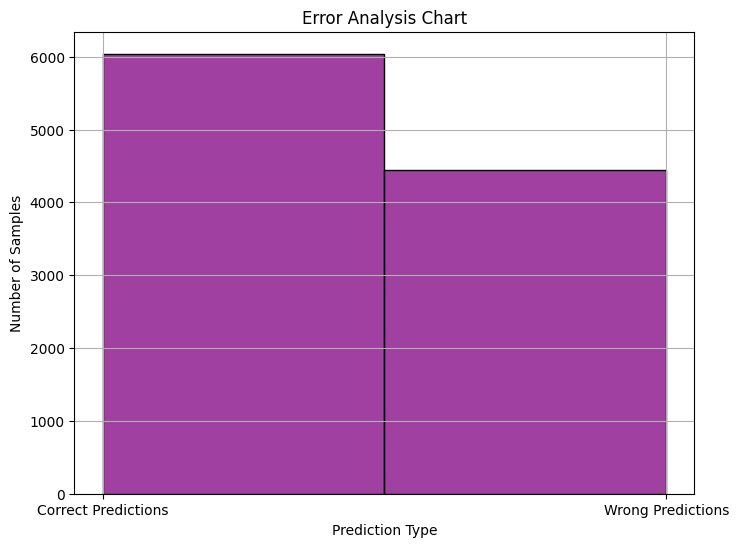

In [ ]:
# نعمل تحليل للأخطاء
errors = (y_pred_best != y_test)

plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=2, kde=False, color='purple')
plt.xticks([0, 1], ['Correct Predictions', 'Wrong Predictions'])
plt.title('Error Analysis Chart')
plt.xlabel('Prediction Type')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()


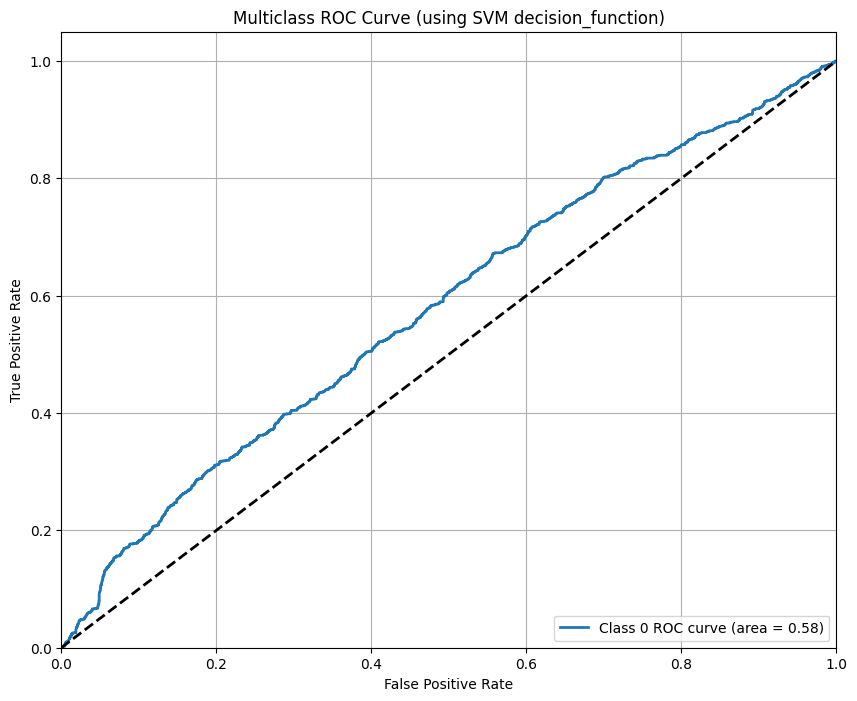

In [ ]:

# ROC Curve
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

y_score = svm_best.decision_function(X_test_scaled)
if n_classes == 1:
    y_score = y_score.reshape(-1, 1)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (using SVM decision_function)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


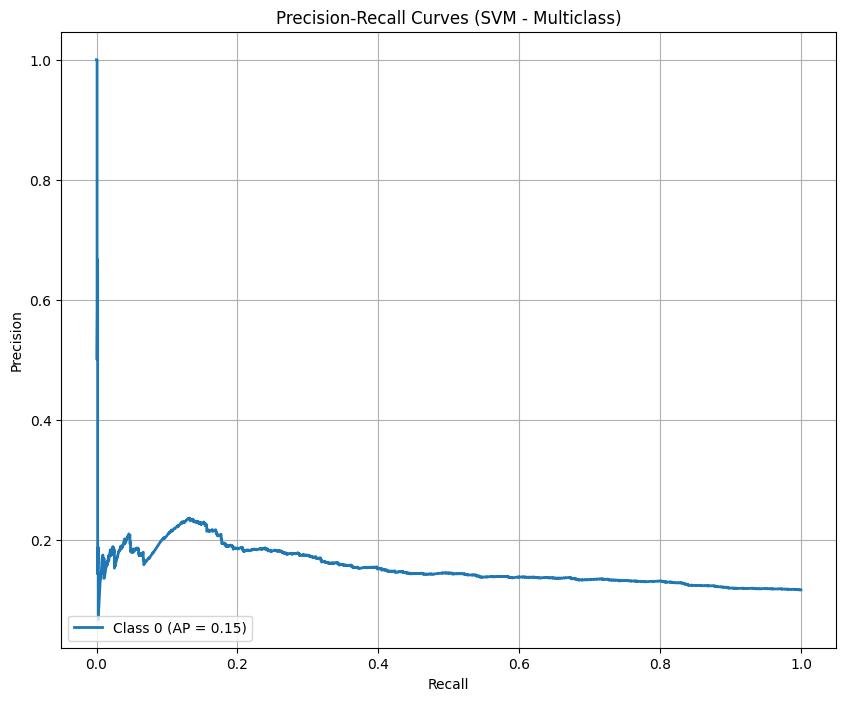

In [ ]:

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    pr_auc = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]} (AP = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (SVM - Multiclass)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()